<a href="https://colab.research.google.com/github/Federico-Villa/TAM-2025-2/blob/main/1%C2%B0_tarea/forma_analitica__y_descendiente_gradiemte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== PARTE A: Proyección entre vectores 2D ===
Alpha analítico: 0.750000
Alpha por GD (final): 0.741353


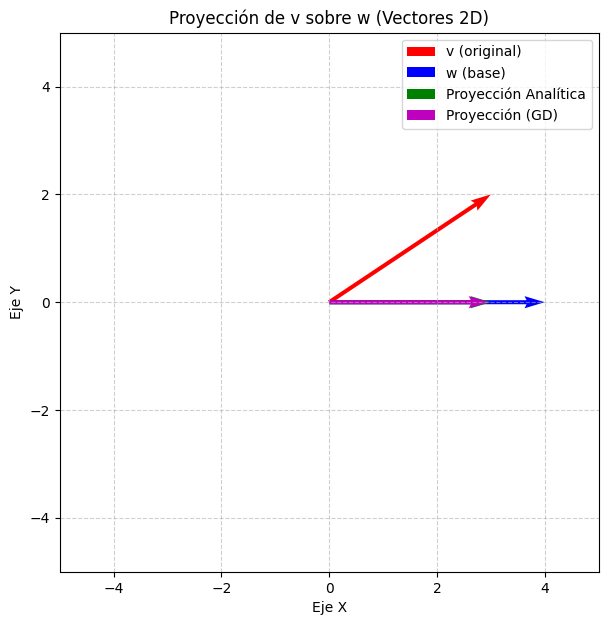

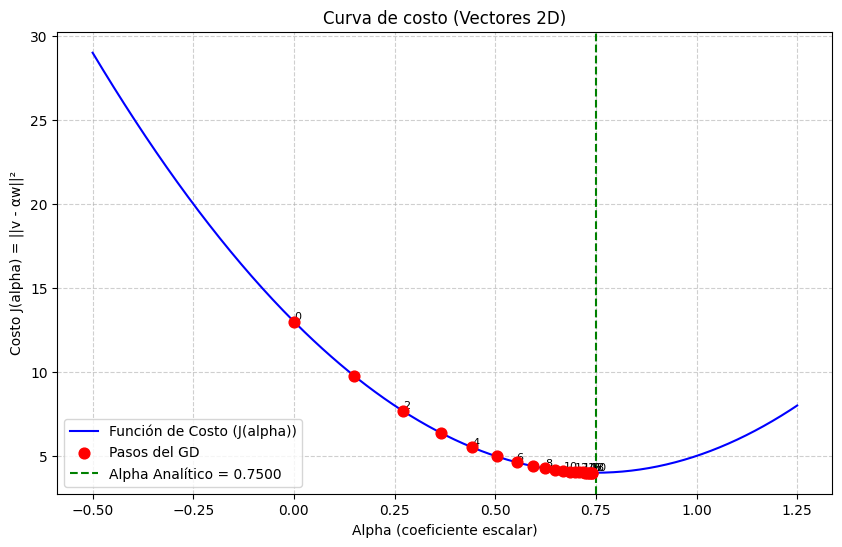


=== PARTE B: Proyección entre imágenes (tratadas como vectores) ===
Imagen v: (1332, 1024), longitud vector: 1363968
Imagen w: (1332, 1024), longitud vector: 1363968
Alpha analítico (imágenes): 0.820542
Alpha GD (imágenes): 0.820542


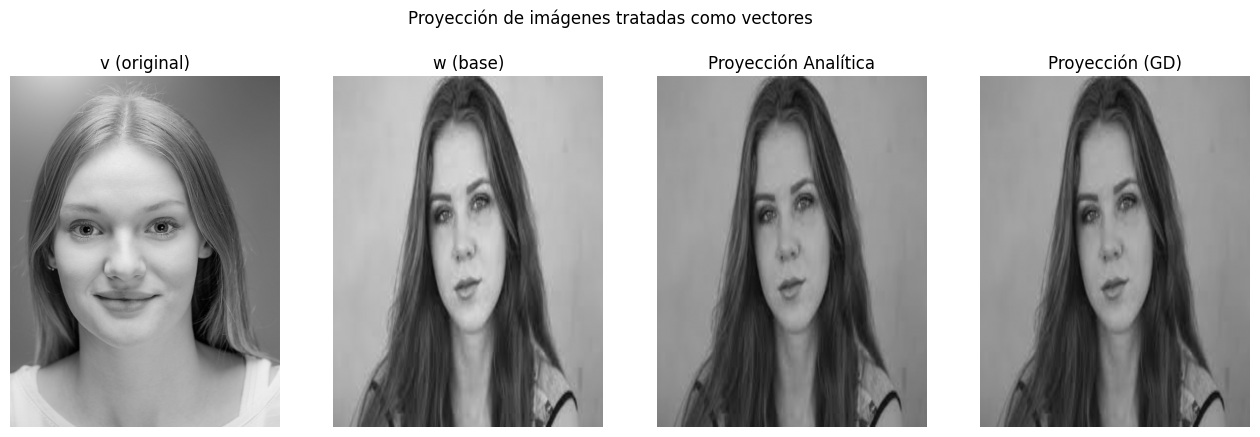

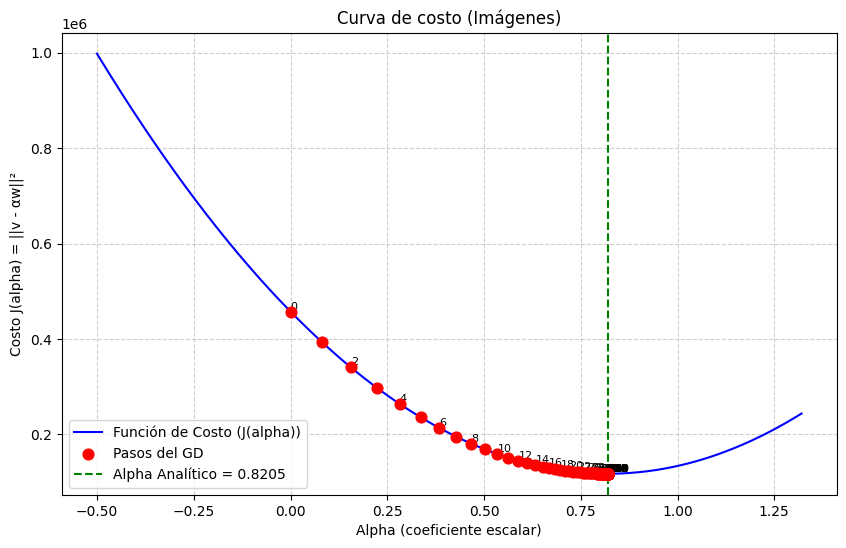

In [ ]:
"""
Proyección lineal: Solución Analítica vs Descenso de Gradiente
-------------------------------------------------------------
Este script compara la proyección de un vector (o imagen tratada como vector)
sobre otro usando dos métodos:
  1. **Solución analítica**: fórmula directa de mínimos cuadrados.
  2. **Descenso de gradiente**: método iterativo de optimización.

Parte A: Demostración con vectores 2D (para visualizar).
Parte B: Demostración con imágenes en escala de grises (rostro_1.jpg, rostro_2.jpg).

Requisito: colocar rostro_1.jpg y rostro_2.jpg en el mismo directorio.
"""

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# -----------------------------
#  Funciones matemáticas básicas
# -----------------------------

def analytical_alpha(v: np.ndarray, w: np.ndarray):
    """
    Calcula el coeficiente óptimo alpha* de la proyección:
        alpha* = <v, w> / <w, w>
    Retorna None si w es el vector cero.
    """
    dot_ww = np.dot(w, w)
    if dot_ww == 0:
        return None
    return np.dot(v, w) / dot_ww

def project_analytic(v: np.ndarray, w: np.ndarray):
    """Devuelve (alpha, vector_proyectado) usando la solución analítica."""
    alpha = analytical_alpha(v, w)
    if alpha is None:
        return None, None
    return alpha, alpha * w

def cost_function(v: np.ndarray, w: np.ndarray, alpha: float):
    """
    Función de costo: J(alpha) = || v - alpha * w ||^2
    Representa el error cuadrático entre v y su proyección.
    """
    r = v - alpha * w
    return float(np.dot(r, r))

def gradient_alpha(v: np.ndarray, w: np.ndarray, alpha: float):
    """
    Calcula el gradiente de J respecto a alpha.
    Fórmula: dJ/dalpha = 2 * (alpha * w^T w - v^T w)
    """
    dot_vw = np.dot(v, w)
    dot_ww = np.dot(w, w)
    return 2.0 * dot_ww * alpha - 2.0 * dot_vw

def gradient_descent_alpha(v: np.ndarray, w: np.ndarray,
                           initial_alpha: float = 0.0,
                           learning_rate: float = None,
                           num_iters: int = 100,
                           record_history: bool = True):
    """
    Encuentra alpha óptimo por descenso de gradiente.

    Parámetros:
    - v: vector original
    - w: vector base
    - initial_alpha: valor inicial de alpha
    - learning_rate: paso de aprendizaje. Si None, se calcula seguro.
    - num_iters: número de iteraciones
    - record_history: si True, guarda historial de alpha y costo.

    Devuelve:
    (alpha_final, lista_alpha_hist, lista_cost_hist)
    """
    dot_ww = np.dot(w, w)
    if dot_ww == 0:
        raise ValueError("El vector w tiene magnitud cero; no se puede proyectar sobre él.")
    # Tasa de aprendizaje segura: menor que 1 / dot_ww
    if learning_rate is None:
        learning_rate = 0.1 / dot_ww
    if learning_rate <= 0 or learning_rate >= 1.0 / dot_ww:
        print("Advertencia: learning_rate fuera del rango estable. Ajustando a valor seguro.")
        learning_rate = 0.1 / dot_ww

    alpha = float(initial_alpha)
    alpha_hist = [alpha] if record_history else None
    cost_hist = [cost_function(v, w, alpha)] if record_history else None

    # Iteraciones de GD
    for k in range(num_iters):
        grad = gradient_alpha(v, w, alpha)
        alpha = alpha - learning_rate * grad
        if record_history:
            alpha_hist.append(alpha)
            cost_hist.append(cost_function(v, w, alpha))

    return alpha, alpha_hist, cost_hist

# -----------------------------
#  Funciones de visualización
# -----------------------------

def plot_vectors_2d(v, w, proj_analytic, proj_gd, title="Proyección en 2D"):
    """
    Grafica los vectores en 2D:
    - v (original)
    - w (base)
    - Proyección analítica
    - Proyección con descenso de gradiente
    """
    fig, ax = plt.subplots(figsize=(7, 7))

    # Dibujar vectores como flechas
    ax.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, color='r', label='v (original)')
    ax.quiver(0, 0, w[0], w[1], angles='xy', scale_units='xy', scale=1, color='b', label='w (base)')

    if proj_analytic is not None:
        ax.quiver(0, 0, proj_analytic[0], proj_analytic[1], angles='xy', scale_units='xy', scale=1, color='g', label='Proyección Analítica')
    if proj_gd is not None:
        ax.quiver(0, 0, proj_gd[0], proj_gd[1], angles='xy', scale_units='xy', scale=1, color='m', label='Proyección (GD)')

    # Ajustar ejes al rango de todos los vectores
    all_vecs = np.vstack([v, w] + ([proj_analytic] if proj_analytic is not None else []) + ([proj_gd] if proj_gd is not None else []))
    max_val = np.max(np.abs(all_vecs)) + 1
    ax.set_xlim(-max_val, max_val)
    ax.set_ylim(-max_val, max_val)
    ax.set_aspect('equal')

    # Detalles extra
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlabel("Eje X")
    ax.set_ylabel("Eje Y")
    ax.set_title(title)
    ax.legend()
    plt.show()

def plot_cost_curve(v, w, alpha_hist, cost_hist, alpha_analytic=None, title="Curva de costo"):
    """
    Grafica:
    - La curva de la función de costo J(alpha)
    - Los pasos del descenso de gradiente como puntos
    - El valor analítico de alpha como línea vertical
    """
    # Rango de alpha para graficar
    alphas_all = alpha_hist[:] if alpha_hist is not None else []
    if alpha_analytic is not None:
        alphas_all = alphas_all + [alpha_analytic]
    if len(alphas_all) == 0:
        x_min, x_max = -1, 1
    else:
        amin = min(alphas_all)
        amax = max(alphas_all)
        delta = max(0.5, 0.2 * (amax - amin) if amax != amin else 0.5)
        x_min, x_max = amin - delta, amax + delta

    coeff_values = np.linspace(x_min, x_max, 400)
    cost_values = [cost_function(v, w, a) for a in coeff_values]

    plt.figure(figsize=(10, 6))
    plt.plot(coeff_values, cost_values, color='blue', label='Función de Costo (J(alpha))')

    # Puntos de GD
    if alpha_hist is not None:
        plt.scatter(alpha_hist, cost_hist, color='red', s=60, zorder=5, label='Pasos del GD')
        for i, (a, c) in enumerate(zip(alpha_hist, cost_hist)):
            if i % 2 == 0:  # marcar cada 2 pasos para no saturar
                plt.text(a, c, f'{i}', fontsize=8, ha='left', va='bottom')

    # Solución analítica
    if alpha_analytic is not None:
        plt.axvline(alpha_analytic, color='g', linestyle='--', label=f'Alpha Analítico = {alpha_analytic:.4f}')

    plt.xlabel('Alpha (coeficiente escalar)')
    plt.ylabel('Costo J(alpha) = ||v - αw||²')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# -----------------------------
#  PARTE A: VECTORES 2D
# -----------------------------
def demo_vectors_2d():
    print("=== PARTE A: Proyección entre vectores 2D ===")
    # Vectores ejemplo
    v = np.array([3.0, 2.0])
    w = np.array([4.0, 0.0])

    # Solución analítica
    alpha_an, proj_an = project_analytic(v, w)
    print(f"Alpha analítico: {alpha_an:.6f}")

    # Descenso de gradiente
    alpha_gd, alpha_hist, cost_hist = gradient_descent_alpha(v, w, initial_alpha=0.0, num_iters=20, record_history=True)
    proj_gd = alpha_gd * w
    print(f"Alpha por GD (final): {alpha_gd:.6f}")

    # Graficar
    plot_vectors_2d(v, w, proj_an, proj_gd, title="Proyección de v sobre w (Vectores 2D)")
    plot_cost_curve(v, w, alpha_hist, cost_hist, alpha_analytic=alpha_an, title="Curva de costo (Vectores 2D)")

# -----------------------------
#  UTILITARIOS PARA IMÁGENES
# -----------------------------
def load_image_as_vector(path, target_size=None, normalize=True):
    """
    Carga una imagen como vector en escala de grises.
    - target_size: (alto, ancho) al que redimensionar.
    - normalize=True: escala a [0,1].
    Devuelve (vector, shape_original).
    """
    img = Image.open(path).convert('L')  # escala de grises
    if target_size is not None:
        img = img.resize((target_size[1], target_size[0]), Image.BILINEAR)
    arr = np.asarray(img, dtype=np.float32)
    shape = arr.shape
    vec = arr.flatten()
    if normalize:
        vec = vec / 255.0
    return vec, shape

def vector_to_image(vec, shape, denormalize=True):
    """Convierte un vector a imagen (alto, ancho)."""
    arr = np.array(vec, dtype=np.float32).reshape(shape)
    if denormalize:
        arr = np.clip(arr * 255.0, 0, 255)
    else:
        arr = np.clip(arr, 0, 255)
    return arr.astype(np.uint8)

# -----------------------------
#  PARTE B: IMÁGENES
# -----------------------------
def demo_images(img_path_v='rostro_1.jpg', img_path_w='rostro_2.jpg'):
    print("\n=== PARTE B: Proyección entre imágenes (tratadas como vectores) ===")

    if not os.path.exists(img_path_v) or not os.path.exists(img_path_w):
        print(f"Advertencia: No se encontraron {img_path_v} y {img_path_w} en el directorio actual.")
        return

    # Cargar imágenes como vectores
    v_vec, v_shape = load_image_as_vector(img_path_v, normalize=True)
    w_vec, _ = load_image_as_vector(img_path_w, target_size=v_shape, normalize=True)

    print(f"Imagen v: {v_shape}, longitud vector: {v_vec.size}")
    print(f"Imagen w: {v_shape}, longitud vector: {w_vec.size}")

    # Proyección analítica
    alpha_an_img = analytical_alpha(v_vec, w_vec)
    if alpha_an_img is None:
        print("No se puede proyectar: w es imagen en blanco.")
        return
    proj_an_vec = alpha_an_img * w_vec
    print(f"Alpha analítico (imágenes): {alpha_an_img:.6f}")

    # Proyección por GD
    dot_ww = np.dot(w_vec, w_vec)
    suggested_lr = 0.05 / dot_ww if dot_ww > 0 else 0.01
    alpha_gd_img, alpha_hist_img, cost_hist_img = gradient_descent_alpha(v_vec, w_vec,
                                                                          initial_alpha=0.0,
                                                                          learning_rate=suggested_lr,
                                                                          num_iters=200,
                                                                          record_history=True)
    proj_gd_vec = alpha_gd_img * w_vec
    print(f"Alpha GD (imágenes): {alpha_gd_img:.6f}")

    # Reconstruir imágenes
    proj_an_img = vector_to_image(proj_an_vec, v_shape)
    proj_gd_img = vector_to_image(proj_gd_vec, v_shape)
    orig_v_img = vector_to_image(v_vec, v_shape)
    orig_w_img = vector_to_image(w_vec, v_shape)

    # Mostrar imágenes
    fig, axes = plt.subplots(1, 4, figsize=(16, 5))
    titles = ['v (original)', 'w (base)', 'Proyección Analítica', 'Proyección (GD)']
    imgs = [orig_v_img, orig_w_img, proj_an_img, proj_gd_img]
    for ax, img, t in zip(axes, imgs, titles):
        ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        ax.set_title(t)
        ax.axis('off')

    plt.suptitle('Proyección de imágenes tratadas como vectores')
    plt.show()

    # Curva de costo
    plot_cost_curve(v_vec, w_vec, alpha_hist_img, cost_hist_img, alpha_analytic=alpha_an_img,
                    title="Curva de costo (Imágenes)")

# -----------------------------
#  EJECUCIÓN
# -----------------------------
if __name__ == "__main__":
    demo_vectors_2d()
    demo_images('rostro_1.jpg', 'rostro_2.jpg')
